Bachelor thesis - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling and transformation
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from pyclustertend import hopkins

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score

import time

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select features
# to run on sample set True otherwise run on whole data set
if (True):
    dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekend']].copy()
    df = dfa.sample(n=30000, random_state=1).copy()
else:
    df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration', 'hour', 'weekend']].copy()

# convert duration into minutes
df['duration'] = df['duration'] / 60

# create cyclical hour feature
df['sin_hour'] = np.sin(2*np.pi*df.hour / 24)
df['cos_hour'] = np.cos(2*np.pi*df.hour / 24)

# create cyclical weekday feature
if (False):
    df['sin_weekday'] = np.sin(2*np.pi*df.weekday / 7)
    df['cos_weekday'] = np.cos(2*np.pi*df.weekday / 7)

# create cyclical weekday feature with workday/weekend gap of 1
if (False):
    df_gap = df[['weekday']].copy()
    df_gap.loc[df_gap['weekday'] > 4, 'weekday'] = df_gap.weekday+1

    df['sin_weekday'] = np.sin(2*np.pi*df_gap.weekday / 9)
    df['cos_weekday'] = np.cos(2*np.pi*df_gap.weekday / 9)

df

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekend,sin_hour,cos_hour
120814,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,3,0,7.071068e-01,0.707107
60088,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,16,0,-8.660254e-01,-0.500000
46984,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,20,1,-8.660254e-01,0.500000
146684,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,13,0,-2.588190e-01,-0.965926
198253,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,20,1,-8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...
71725,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjczNjUw,car,1384,1149,64.716667,15,0,-7.071068e-01,-0.707107
373590,YmlrZTo6dGllcjo6ZmZiNjJlZDctZjBiMi00OGMxLWE2NT...,scooter,4465,4396,9.966667,12,0,1.224647e-16,-1.000000
330644,YmlrZTo6dGllcjo6ZWQwNDdiMWQtZGQxYy00MTgzLTlhZm...,scooter,3646,571,25.016667,14,1,-5.000000e-01,-0.866025
202888,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzg0NTA5,car,1970,3675,50.016667,15,0,-7.071068e-01,-0.707107


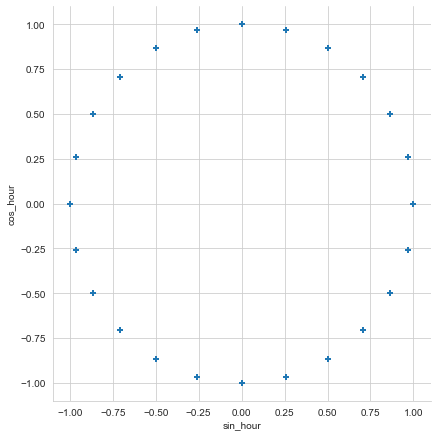

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="sin_hour", y="cos_hour", kind="scatter", data=df, marker='+', height=6, aspect=1)

In [7]:
# plot features to visually observe structure of data
#g = sns.relplot(x="sin_weekday", y="cos_weekday", kind="scatter", data=df, marker='+', height=6, aspect=1)

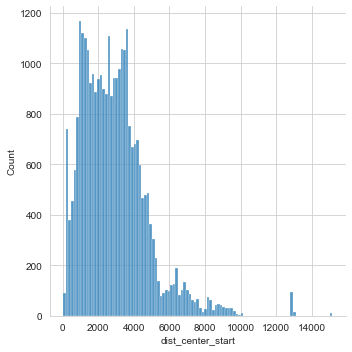

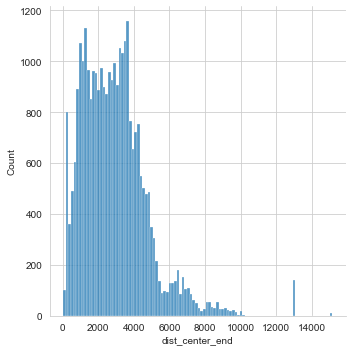

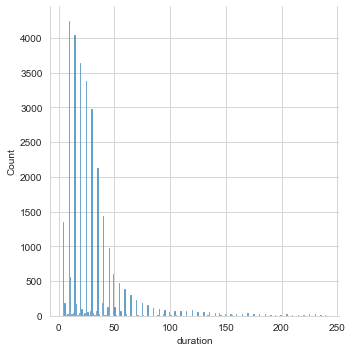

In [8]:
# univariate distribution of numeric variables
for column in df[['dist_center_start','dist_center_end', 'duration']].columns:
    sns.displot(df, x=column)

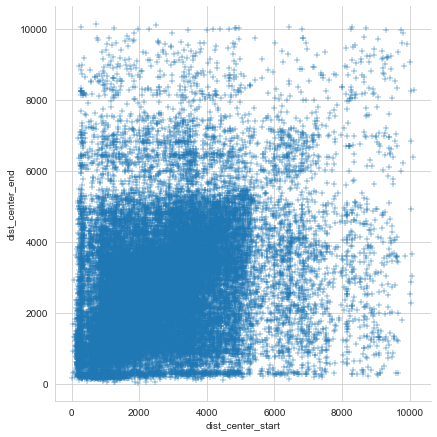

In [9]:
# remove extreme outliers due to sensibility of k-means regarding outliers
# has to be considered that trips outside the operation area or to and from isolated operation areas (e.g. airport) are removed
df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)].reset_index(drop=True)

# plot result
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=6, aspect=1)

### Feature scaling

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'hour'),
  Text(4, 0, 'weekend'),
  Text(5, 0, 'sin_hour'),
  Text(6, 0, 'cos_hour')])

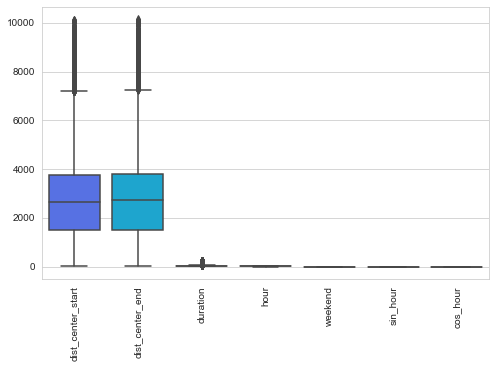

In [10]:
# look at feature scale
plt.figure(figsize=(8,5))
sns.boxplot(data=df, palette='rainbow')
plt.xticks(rotation=90)

In [11]:
# normalize features to get same range as sin and cos values
dfnorm = df[['dist_center_start','dist_center_end', 'duration', 'weekend']].copy()

# column names
names = dfnorm.columns
# create scaler object
scaler = StandardScaler()
# fit data on scaler object
dfnorm = scaler.fit_transform(dfnorm)
dfnorm = pd.DataFrame(dfnorm, columns=names)
# normalize data
dfnorm = normalize(dfnorm) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(dfnorm, columns=names) 

scaled_df = df[['sin_hour','cos_hour']].copy()
scaled_df = pd.concat([scaled_df, normalized_df], axis=1)
scaled_df

# assign weight to variables to compensate for double appearance of time related features
feature_weight = 1.5
feature_weight2 = 1.5

scaled_df['duration'] = scaled_df['duration'] * feature_weight2
scaled_df['dist_center_start'] = scaled_df['dist_center_start'] * feature_weight
scaled_df['dist_center_end'] = scaled_df['dist_center_end'] * feature_weight

#scaled_df['sin_weekday'] = scaled_df['sin_weekday'] / 1.5
#scaled_df['cos_weekday'] = scaled_df['cos_weekday'] / 1.5

scaled_df['weekend'] = scaled_df['weekend'] / 1

# square std to check variance of features
scaled_df.std()*scaled_df.std()

sin_hour             0.515453
cos_hour             0.384324
dist_center_start    0.546206
dist_center_end      0.555926
duration             0.354420
weekend              0.330890
dtype: float64

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'sin_hour'),
  Text(1, 0, 'cos_hour'),
  Text(2, 0, 'dist_center_start'),
  Text(3, 0, 'dist_center_end'),
  Text(4, 0, 'duration'),
  Text(5, 0, 'weekend')])

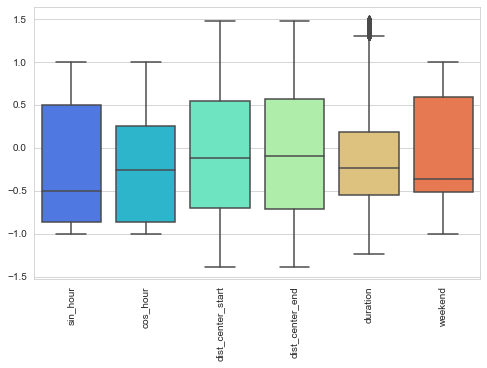

In [12]:
# visualize scaled features
plt.figure(figsize=(8,5))
sns.boxplot(data=scaled_df, palette='rainbow')
plt.xticks(rotation=90)

### Cluster tendency

In [13]:
# calculate hopkins statistics on subset (5% of data)
subset5perc = int(len(scaled_df) * 0.05)
hopkins(scaled_df, subset5perc)

0.17105731087887566

### Clustering trip types via k-means 

#### Parameter selection / clustering performance evaluation

In [14]:
# run k-means multiple times to identify "optimal" k

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# calinski_harabasz_score
calinski_harabasz_scores = []

# davies_bouldin_score
davies_bouldin_scores = []

# select range max value for for-loop
max_num_cluster = 30

# run loop
for i in range (2,max_num_cluster):   
    start = time.time()
    print(i)
    
    kmeans = KMeans(n_clusters=i, n_init=20)
    kmeans.fit(scaled_df)
    
    wcss.append(kmeans.inertia_)
    print('inertia: ', kmeans.inertia_)
        
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print('silhouette: ',score)
    
    score_cal = metrics.calinski_harabasz_score(scaled_df, kmeans.labels_)
    calinski_harabasz_scores.append(score_cal)
    print('calinski harabasz: ',score_cal)
    
    score_db = davies_bouldin_score(scaled_df, kmeans.labels_)
    davies_bouldin_scores.append(score_db)
    print('davies bouldin: ',score_db)

    end = time.time()
    print(end - start)

2
inertia:  64066.37562539917
silhouette:  0.1936277184199921
calinski harabasz:  7352.181212314885
davies bouldin:  1.9847442961323092
19.94322633743286
3
inertia:  56247.91870321044
silhouette:  0.17921518193723204
calinski harabasz:  6253.439781280428
davies bouldin:  1.894294570099599
20.7068452835083
4
inertia:  50404.317068389944
silhouette:  0.175784113235058
calinski harabasz:  5801.287138436889
davies bouldin:  1.8345371259782173
21.67404294013977
5
inertia:  45626.73730615034
silhouette:  0.19328922324041342
calinski harabasz:  5584.621667673984
davies bouldin:  1.659377486134272
23.202914714813232
6
inertia:  41792.189801858156
silhouette:  0.20012951044215008
calinski harabasz:  5423.024870471646
davies bouldin:  1.5280605482276115
23.430224418640137
7
inertia:  38741.70749795911
silhouette:  0.20346059156665372
calinski harabasz:  5265.036691170565
davies bouldin:  1.4225165691097543
27.380793809890747
8
inertia:  36069.822646166016
silhouette:  0.21834463670064946
calinsk

#### Elbow method

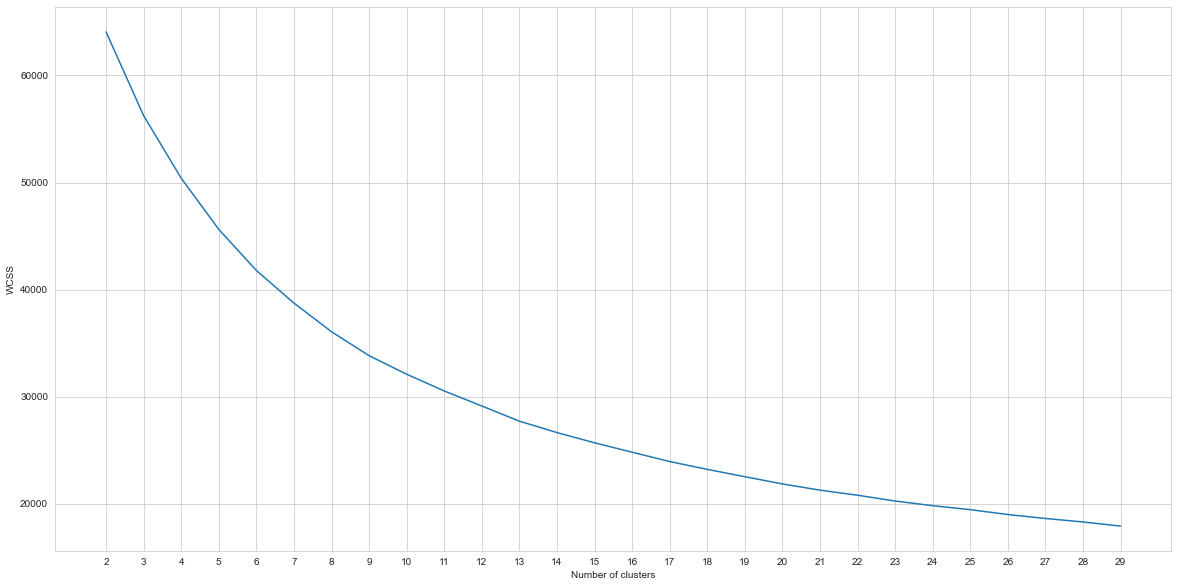

In [15]:
# plot wcss for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), wcss)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()
#fig.savefig('elbowPlot2.png', dpi=fig.dpi)

#### Silhouette coefficient

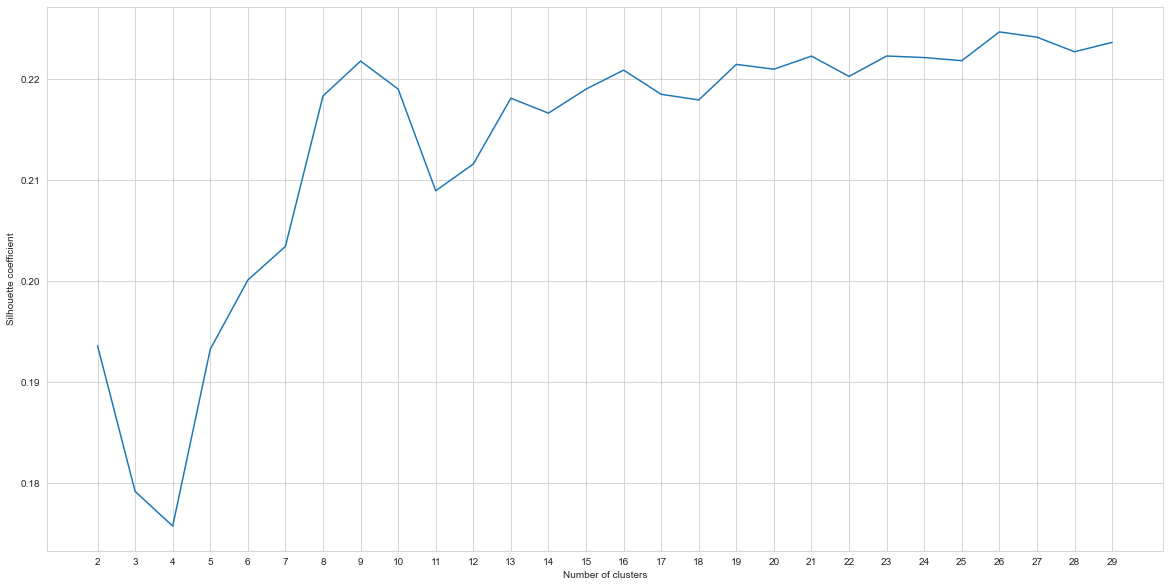

In [16]:
# plot silhouette coefficients for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), silhouette_coefficients)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()
#fig.savefig('silhouetteScore2.png', dpi=fig.dpi)

#### Calinski Harabasz score

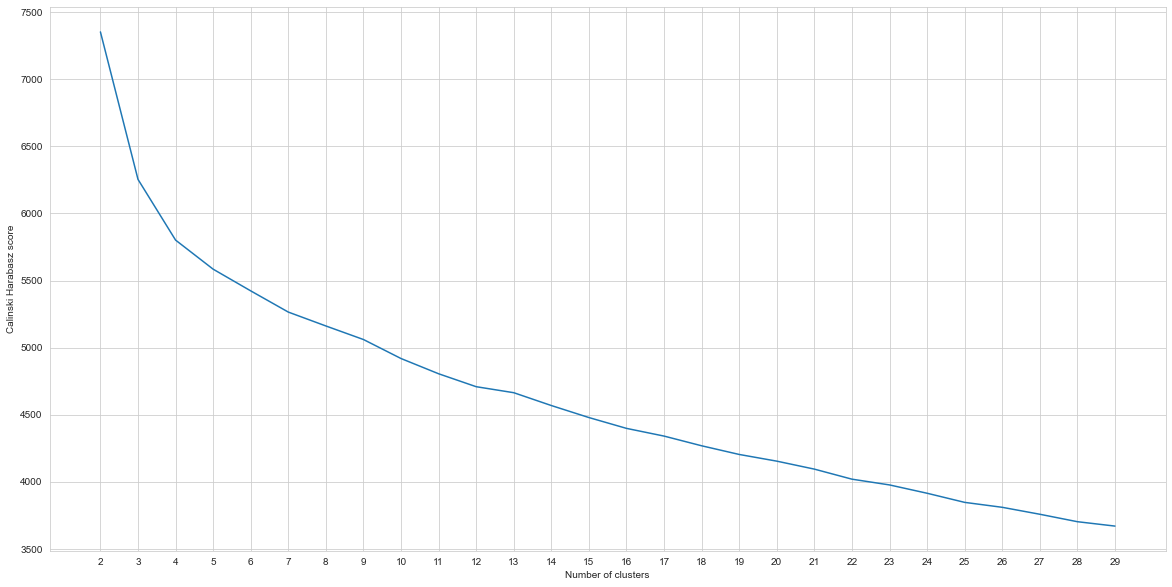

In [17]:
# plot Calinski Harabasz score for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), calinski_harabasz_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski Harabasz score")
plt.show()
#fig.savefig('calinskiHarabaszScore2.png', dpi=fig.dpi)

#### Davies Bouldin index

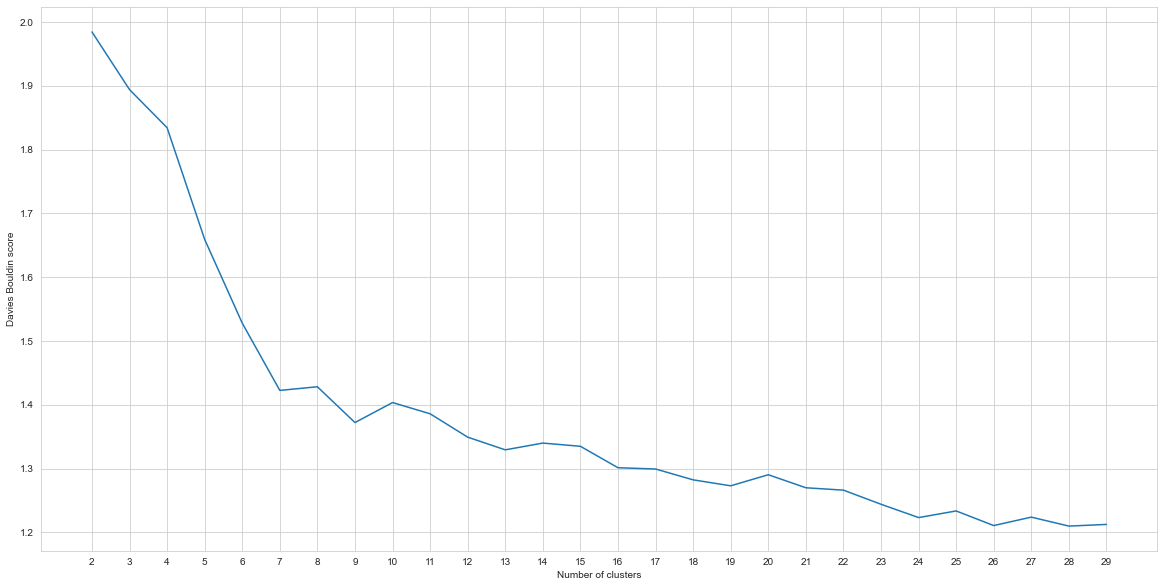

In [18]:
# plot Davies Bouldin scores for each k
fig = plt.figure(figsize=(20, 10))
plt.plot(range(2, max_num_cluster), davies_bouldin_scores)
plt.xticks(range(2, max_num_cluster))
plt.xlabel("Number of clusters")
plt.ylabel("Davies Bouldin score")
plt.show()
#fig.savefig('daviesBouldinScore2.png', dpi=fig.dpi)

#### K-means with selected parameter

In [19]:
# cluster data for the chosen number of clusters
k = 10

# run k-means
kmeans = KMeans(n_clusters=k,  n_init=100, max_iter=5000, random_state=0).fit(scaled_df)

# create dataframe of trips with cluster column
clustered_data = df.copy()
cluster_labels = kmeans.fit_predict(scaled_df)
clustered_data['cluster'] = cluster_labels
scaled_df['cluster'] = cluster_labels

clustered_data.head()

,id,vehicleType,dist_center_start,dist_center_end,duration,hour,weekend,sin_hour,cos_hour,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,3,0,0.707107,0.707107,5
1,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,16,0,-0.866025,-0.500000,0
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,20,1,-0.866025,0.500000,3
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,13,0,-0.258819,-0.965926,5
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,20,1,-0.866025,0.500000,3


### Interpretation of results

#### Cluster cardinality

<AxesSubplot:xlabel='cluster', ylabel='count'>

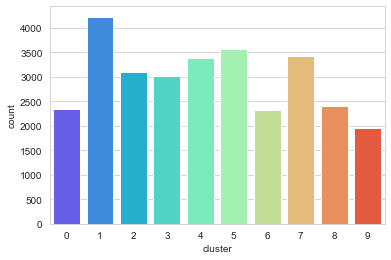

In [20]:
# show cardinality (sum of instances) of clusters
sns.countplot(x="cluster", data=clustered_data, palette='rainbow')

#### Attribute table

In [21]:
# create an attribute table to interpret cluster results
# create table with cardinality columns
cluster_cardinality = clustered_data.groupby(['cluster']).count().iloc[:,:2].copy()
cluster_cardinality.columns = ['cardinality', 'proportion']
instances = len(clustered_data)
cluster_cardinality['proportion'] = cluster_cardinality['cardinality'] / instances * 100
interpret_df = cluster_cardinality

# create table with means of numeric features
means = clustered_data[['dist_center_start', 'dist_center_end', 'duration', 'weekend', 'cluster']].copy()
means = means.groupby(['cluster']).mean()

# merge 2 dataframes
interpret_df = interpret_df.join(means)

# create table with percentages for each categorical value
time_df = clustered_data[['hour','cluster']].copy()

#dayOfWeek={0:'0 Monday', 1:'1 Tuesday', 2:'2 Wednesday', 3:'3 Thursday', 4:'4 Friday', 5:'5 Saturday', 6:'6 Sunday'}
#time_df['weekday'] = time_df['weekday'].map(dayOfWeek)
#time_df = time_df.join(pd.get_dummies(time_df['weekday']))
#time_df = time_df.drop(['weekday'],axis=1)

time_df = time_df.join(pd.get_dummies(time_df['hour']))
time_df = time_df.drop(['hour'],axis=1)

time_df = time_df.groupby(['cluster']).sum()

count = clustered_data.groupby(['cluster'])['id'].count().copy()

for i in count.index:
    for col in time_df.columns:
        time_df[col][i] = time_df[col][i] / count[i] * 100

# merge dataframes
interpret_df = interpret_df.join(time_df)

# save files set True
if (False):
    interpret_df.T.round(2).to_excel("Final-19-15-18-15-15-InterpretClusters.xlsx")  
    interpret_df.to_csv('finalclusters.csv', index=False)
    scaled_df.to_csv('scaledDataWithFinalClusters.csv', index=False)

# display whole dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)
interpret_df.T.round(2)

cluster,0,1,2,3,4,5,6,7,8,9
cardinality,2348.00,4227.00,3102.00,3008.00,3378.00,3562.00,2313.00,3426.00,2412.00,1961.00
proportion,7.90,14.21,10.43,10.12,11.36,11.98,7.78,11.52,8.11,6.59
dist_center_start,5104.88,1632.52,3648.47,2310.59,2315.81,1571.17,2883.16,4266.06,1597.68,4470.11
dist_center_end,2118.45,1609.16,4982.45,2595.84,2393.58,1669.48,3006.21,4497.87,4287.50,1709.13
duration,36.10,17.23,28.63,21.46,23.05,17.12,96.56,20.54,30.00,34.00
weekend,0.16,0.01,0.16,1.00,1.00,0.03,0.21,0.10,0.04,0.10
0,0.51,2.53,0.00,9.18,0.00,0.00,0.30,1.90,2.45,0.66
1,0.00,1.68,0.45,6.12,0.00,0.00,0.22,0.90,1.24,1.58
2,0.00,0.00,1.45,4.69,0.00,1.71,0.13,0.00,0.95,1.33
3,0.00,0.00,1.97,2.16,0.00,1.15,0.39,0.00,0.25,2.14


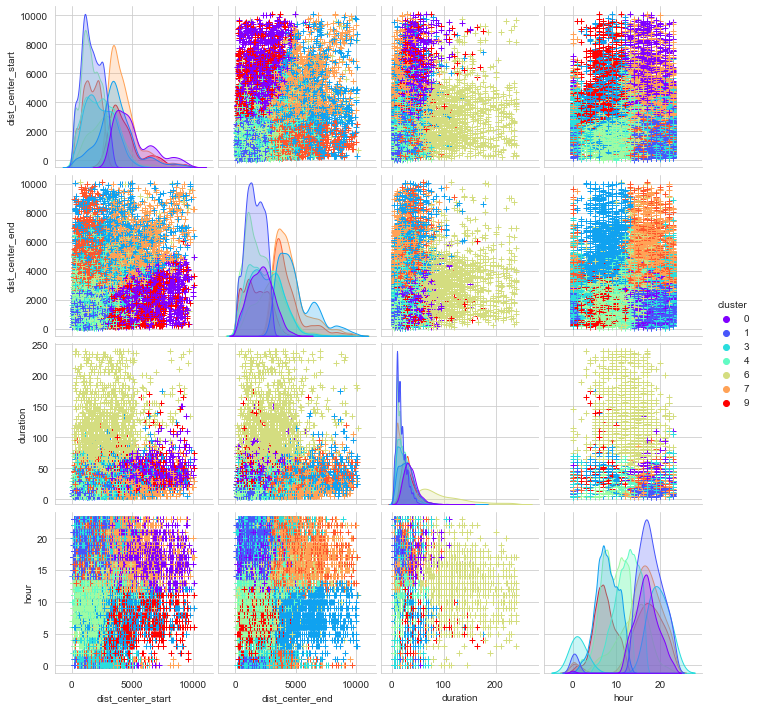

In [22]:
# show pairwise relation
sns.pairplot(clustered_data[['dist_center_start','dist_center_end','duration','hour','cluster']], hue="cluster", plot_kws=dict(marker="+", linewidth=1), palette='rainbow')

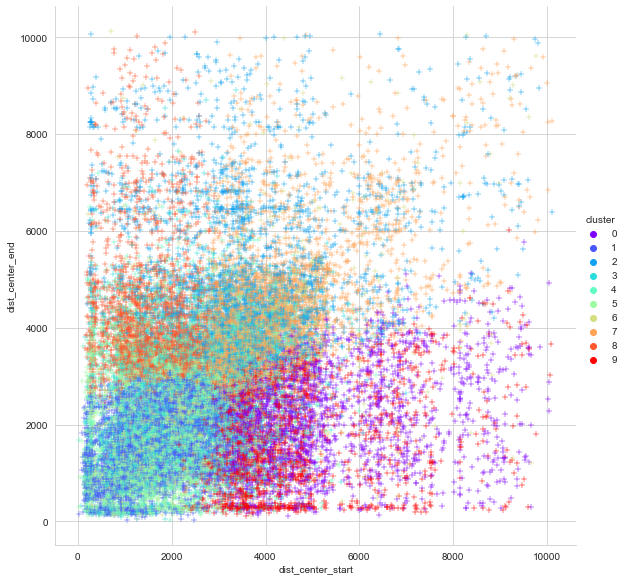

In [23]:
# plot cluster results for two desired features
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=clustered_data, marker='+', hue='cluster', palette='rainbow', legend='full', height=8, aspect=1)

#### Trip type characteristics description

#### Cluster visualization with t-SNE

In [24]:
#TSNE_data = scaled_df.copy()
#sampleTSNE = TSNE_data.sample(n=40000, random_state=1).reset_index()
sampleTSNE = scaled_df.copy()
# cluster data for the chosen number of clusters
#k = 19
#k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
#clusters = k_means_new.fit_predict(sampleTSNE)
#sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X = sampleTSNE.iloc[:,1:-1]

##########################################
tsne = TSNE(n_components=2, perplexity=100.0, n_iter=5000, verbose=1).fit_transform(X)

tsne

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 29737 samples in 0.096s...
[t-SNE] Computed neighbors for 29737 samples in 7.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29737
[t-SNE] Computed conditional probabilities for sample 2000 / 29737
[t-SNE] Computed conditional probabilities for sample 3000 / 29737
[t-SNE] Computed conditional probabilities for sample 4000 / 29737
[t-SNE] Computed conditional probabilities for sample 5000 / 29737
[t-SNE] Computed conditional probabilities for sample 6000 / 29737
[t-SNE] Computed conditional probabilities for sample 7000 / 29737
[t-SNE] Computed conditional probabilities for sample 8000 / 29737
[t-SNE] Computed conditional probabilities for sample 9000 / 29737
[t-SNE] Computed conditional probabilities for sample 10000 / 29737
[t-SNE] Computed conditional probabilities for sample 11000 / 29737
[t-SNE] Computed conditional probabilities for sample 12000 / 29737
[t-SNE] Computed conditional probabilities for sa

array([[  57.815605  ,  -63.492847  ],
       [  -0.76817894,   71.536354  ],
       [-130.10182   ,   -1.3582981 ],
       ...,
       [ -96.236046  ,  -62.78008   ],
       [  35.17918   ,  -38.281487  ],
       [ -27.780756  ,   24.589653  ]], dtype=float32)

In [25]:
cluster_label_tsne = sampleTSNE['cluster']

tsne_cluster = pd.DataFrame(tsne)
tsne_cluster['cluster'] = cluster_label_tsne
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster.columns = ['x1','x2','cluster']
tsne_cluster.head()
#sampleTSNE['cluster']


,x1,x2,cluster
0,57.815605,-63.492847,5
1,-0.768179,71.536354,0
2,-130.101822,-1.358298,3
3,61.855370,-7.050801,5
4,-133.880386,17.863869,3


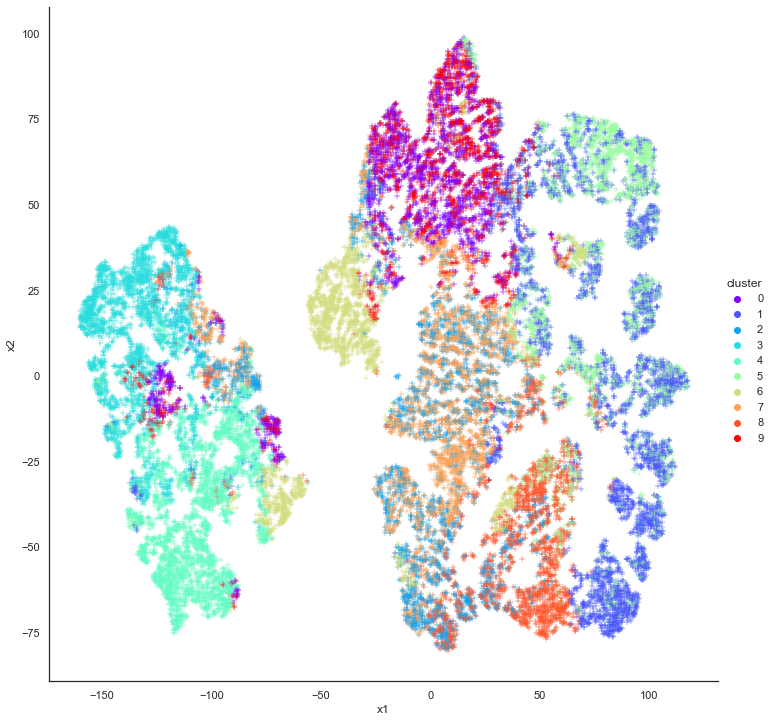

In [26]:
sns.set_theme(style="white")

sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

In [44]:
len(data_full[data_full['speed']>50].head())

5

In [27]:
#TSNE_data2 = scaled_df.copy()
#sampleTSNE2 = TSNE_data2.sample(n=40000, random_state=1).reset_index()
sampleTSNE2 = scaled_df.copy()
# cluster data for the chosen number of clusters
#k = 19
#k_means_new = KMeans(n_clusters=k, random_state=0).fit(sampleTSNE)

#clustered_data = df.copy()
#clusters = k_means_new.fit_predict(sampleTSNE)
#sampleTSNE['cluster'] = clusters

from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X2 = sampleTSNE2.iloc[:,1:-1]

##########################################
tsne2 = TSNE(n_components=2, perplexity=30.0, n_iter=5000, verbose=1).fit_transform(X2)

tsne2

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 29737 samples in 0.043s...
[t-SNE] Computed neighbors for 29737 samples in 1.427s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29737
[t-SNE] Computed conditional probabilities for sample 2000 / 29737
[t-SNE] Computed conditional probabilities for sample 3000 / 29737
[t-SNE] Computed conditional probabilities for sample 4000 / 29737
[t-SNE] Computed conditional probabilities for sample 5000 / 29737
[t-SNE] Computed conditional probabilities for sample 6000 / 29737
[t-SNE] Computed conditional probabilities for sample 7000 / 29737
[t-SNE] Computed conditional probabilities for sample 8000 / 29737
[t-SNE] Computed conditional probabilities for sample 9000 / 29737
[t-SNE] Computed conditional probabilities for sample 10000 / 29737
[t-SNE] Computed conditional probabilities for sample 11000 / 29737
[t-SNE] Computed conditional probabilities for sample 12000 / 29737
[t-SNE] Computed conditional probabilities for sam

array([[146.39522  , -19.327404 ],
       [ -6.1211734, -35.6976   ],
       [ 42.34194  , 108.50461  ],
       ...,
       [-73.75925  ,  77.101944 ],
       [-16.701897 , -57.811752 ],
       [ 12.968935 , -90.215515 ]], dtype=float32)

In [28]:
cluster_label_tsne2 = sampleTSNE2['cluster']

tsne_cluster2 = pd.DataFrame(tsne2)
tsne_cluster2['cluster'] = cluster_label_tsne2
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster2.columns = ['x1','x2','cluster']
tsne_cluster2.head()
#sampleTSNE['cluster']

,x1,x2,cluster
0,146.395218,-19.327404,5
1,-6.121173,-35.697601,0
2,42.341942,108.504608,3
3,-53.780327,-17.449764,5
4,47.752953,138.157684,3


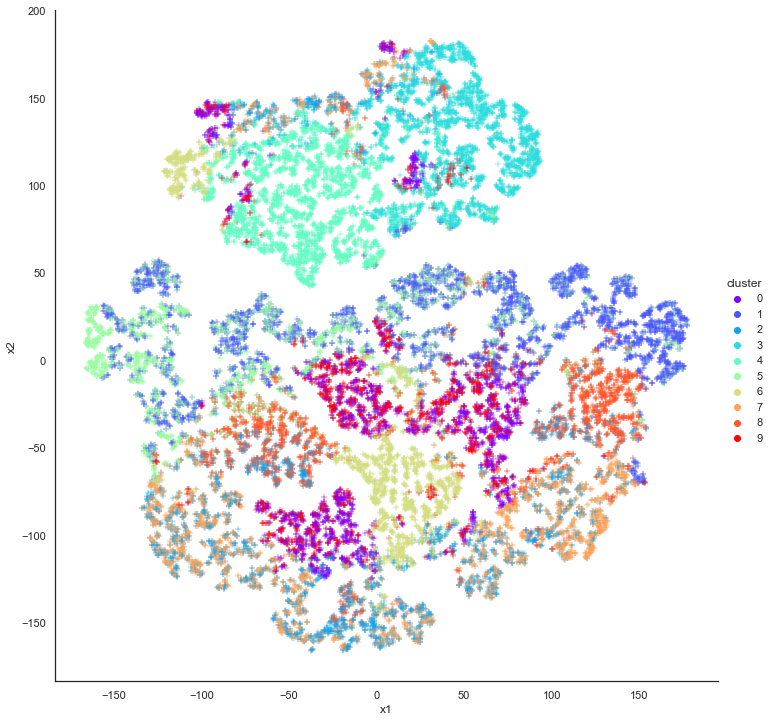

In [29]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster2, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

In [30]:
#TSNE_data3 = scaled_df.copy()
#sampleTSNE3 = TSNE_data3.sample(n=40000, random_state=1).reset_index()
sampleTSNE3 = scaled_df.copy()


from sklearn.manifold import TSNE
# perplexity parameter can be changed based on the input datatset
# dataset with larger number of variables requires larger perplexity
# set this value between 5 and 50 (sklearn documentation)
# verbose=1 displays run time messages
# set n_ite sufficiently high to resolve the well stabilized cluster
# get embeddings

X3 = sampleTSNE3.iloc[:,1:-1]

##########################################
tsne3 = TSNE(n_components=2, perplexity=50.0, n_iter=5000, verbose=1).fit_transform(X3)

tsne3

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 29737 samples in 0.040s...
[t-SNE] Computed neighbors for 29737 samples in 1.915s...
[t-SNE] Computed conditional probabilities for sample 1000 / 29737
[t-SNE] Computed conditional probabilities for sample 2000 / 29737
[t-SNE] Computed conditional probabilities for sample 3000 / 29737
[t-SNE] Computed conditional probabilities for sample 4000 / 29737
[t-SNE] Computed conditional probabilities for sample 5000 / 29737
[t-SNE] Computed conditional probabilities for sample 6000 / 29737
[t-SNE] Computed conditional probabilities for sample 7000 / 29737
[t-SNE] Computed conditional probabilities for sample 8000 / 29737
[t-SNE] Computed conditional probabilities for sample 9000 / 29737
[t-SNE] Computed conditional probabilities for sample 10000 / 29737
[t-SNE] Computed conditional probabilities for sample 11000 / 29737
[t-SNE] Computed conditional probabilities for sample 12000 / 29737
[t-SNE] Computed conditional probabilities for sa

array([[ -38.30818 ,   69.889435],
       [  58.436962,  -31.289818],
       [  26.033012,  -99.830055],
       ...,
       [ -22.435637, -106.280266],
       [ -79.754   ,   83.48259 ],
       [  29.06811 ,    7.999682]], dtype=float32)

In [31]:
cluster_label_tsne3 = sampleTSNE3['cluster']

tsne_cluster3 = pd.DataFrame(tsne3)
tsne_cluster3['cluster'] = cluster_label_tsne3
#tsne_cluster['cluster'] = sampleTSNE['cluster']
tsne_cluster3.columns = ['x1','x2','cluster']
tsne_cluster3.head()
#sampleTSNE['cluster']

,x1,x2,cluster
0,-38.308182,69.889435,5
1,58.436962,-31.289818,0
2,26.033012,-99.830055,3
3,-29.715227,117.401054,5
4,56.133057,-105.976944,3


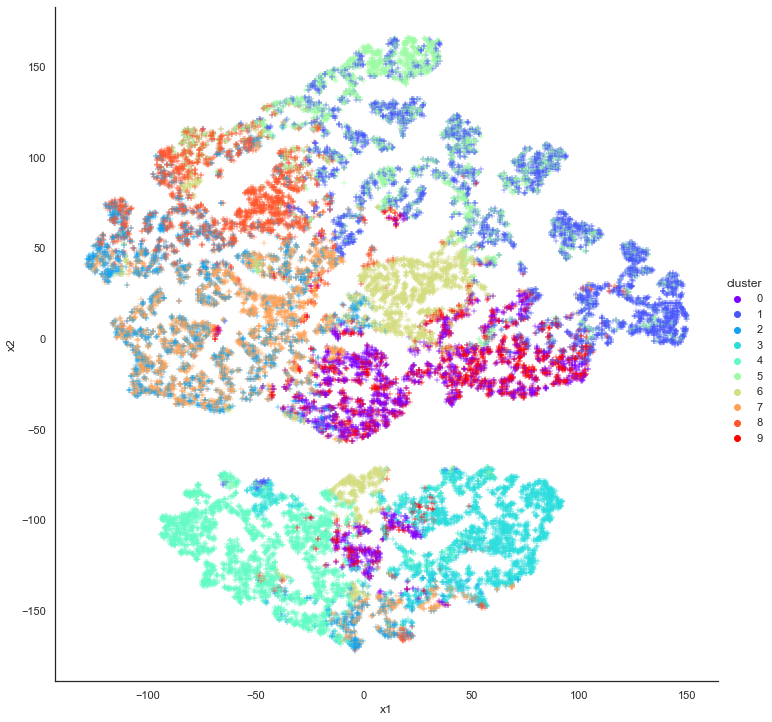

In [32]:
sns.relplot(x="x1", y="x2", kind="scatter", data=tsne_cluster3, hue='cluster', marker='+', palette ='rainbow', legend="full", height=10, aspect=1)

#### Radar plot

In [33]:
#clustered_data.groupby(['cluster']).describe()

### Distribution of trip types within mobility modes

In [34]:
# show distribution of each mobility mode for the identified trip types
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution {} [%]'.format(mode)] = distribution['id'] / trip_volume *100

    return distribution[['Distribution {} [%]'.format(mode)]]

In [35]:
car = create_distribution_overview('car')
bicycle = create_distribution_overview('bicycle')
scooter = create_distribution_overview('scooter')
df_distribution = car.merge(bicycle, how='left', on='cluster')
df_distribution = df_distribution.merge(scooter, how='left', on='cluster')
df_distribution

,Distribution car [%],Distribution bicycle [%],Distribution scooter [%]
cluster,,,
0,11.946361,3.784344,1.301342
1,6.933007,21.980301,25.996340
2,13.048075,6.635562,6.394876
3,8.852660,9.175739,12.606751
4,9.709548,13.841369,13.887759
5,6.409971,19.180923,20.740138
6,11.567995,6.894764,1.026840
7,11.100601,7.568688,13.064254
8,10.866904,6.531882,3.385523
